In [1]:
# Required libraries
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# read data
def parse_data(file):
    for l in open(file,'r'):
        yield json.loads(l)

data = list(parse_data('G:\\NLP Projects\\Sarcasm Detection\\data\\Sarcasm_Headlines_Dataset_v2.json'))

# convert to pandas dataframe
df = pd.DataFrame(data)
df.head()


,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


`article_link` column is useless. So let's get rid of it.

In [4]:
df = df[['is_sarcastic', 'headline']]
df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


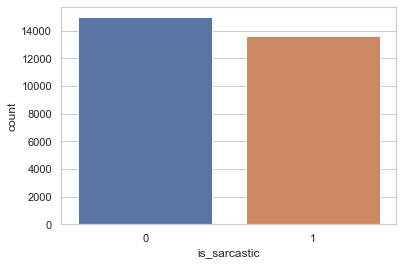

In [5]:
sns.set_theme(style="whitegrid")
sns.countplot(x = 'is_sarcastic', data = df);

The dataset is pretty balanced.

### Let's check the length of the texts.

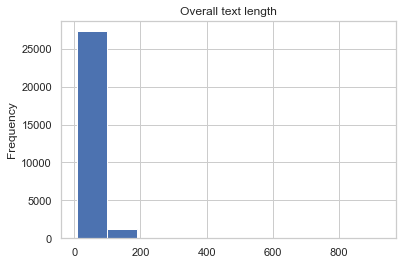

In [6]:
text_length = df['headline'].drop_duplicates().apply(len)
text_length.plot(kind='hist')
plt.title('Overall text length');

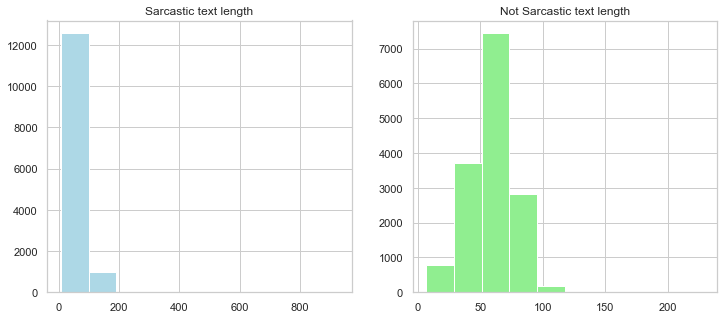

In [7]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,5))
text_len=df[df['is_sarcastic']==1]['headline'].drop_duplicates().apply(len)
ax1.hist(text_len,color='lightblue')
ax1.set_title('Sarcastic text length')
text_len=df[df['is_sarcastic']==0]['headline'].drop_duplicates().apply(len)
ax2.hist(text_len,color='lightgreen')
ax2.set_title('Not Sarcastic text length');

### Let's check the word count of the texts.

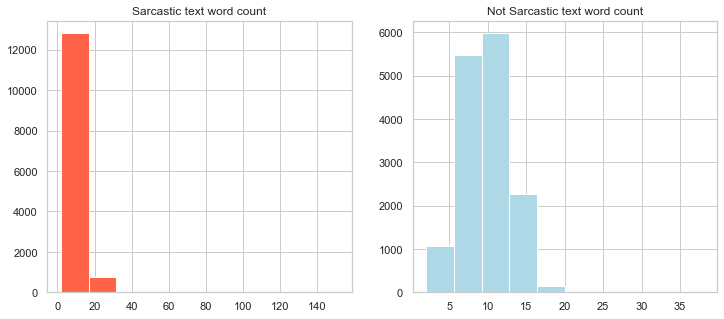

In [8]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,5))
text_len=df[df['is_sarcastic']==1]['headline'].drop_duplicates().str.split().map(lambda x: len(x))
ax1.hist(text_len,color='tomato')
ax1.set_title('Sarcastic text word count')
text_len=df[df['is_sarcastic']==0]['headline'].drop_duplicates().str.split().map(lambda x: len(x))
ax2.hist(text_len,color='lightblue')
ax2.set_title('Not Sarcastic text word count');

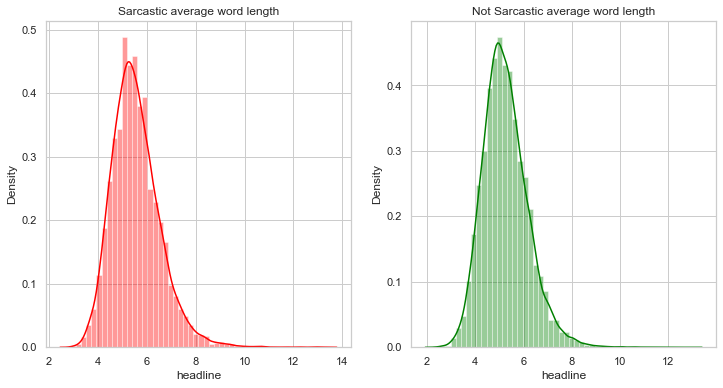

In [9]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,6))
word=df[df['is_sarcastic']==1]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Sarcastic average word length')
word=df[df['is_sarcastic']==0]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not Sarcastic average word length');

## Ngram

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(corpus, n=None, remove_stop_words=False, n_words=1): 
    
    if remove_stop_words:
        vec = CountVectorizer(stop_words = 'english', ngram_range=(n_words, n_words)).fit(corpus)
    else:
        vec = CountVectorizer(ngram_range=(n_words, n_words)).fit(corpus)
        
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def plot_ngram(words, color = "#120f7a"):
    
    fig = plt.figure(figsize=(12,6))
    df = pd.DataFrame(words, columns = ['text' , 'count'])
    ax1 = df.groupby('text').sum()['count'].sort_values(ascending=False).plot(
        kind='bar', color = color)

### Unigrams

In [11]:
unigram_words = get_top_n_words(df['headline'], 20, remove_stop_words=True, n_words=1)
for word, freq in unigram_words:
    print(word, freq)

trump 1832
new 1684
man 1525
just 676
report 605
year 587
woman 549
day 523
area 501
time 496
says 485
donald 478
like 454
people 429
obama 428
old 424
women 417
nation 412
life 410
world 405


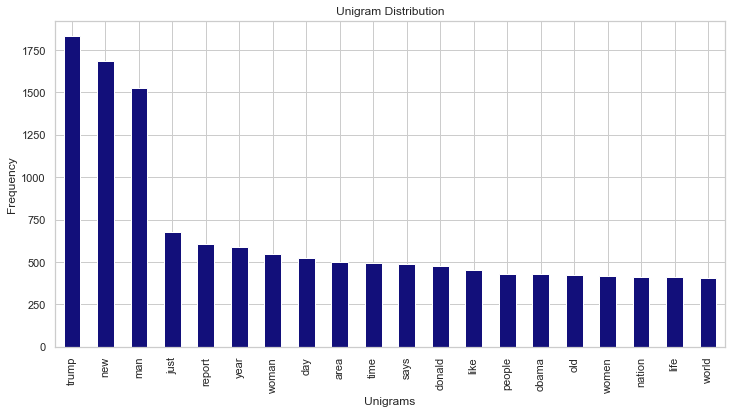

In [12]:
plot_ngram(unigram_words)
plt.title('Unigram Distribution')
plt.xlabel("Unigrams")
plt.ylabel("Frequency");

### Bigrams

In [13]:
bigram_words = get_top_n_words(df['headline'], 20, remove_stop_words=True, n_words=2)
for word, freq in bigram_words:
    print(word, freq)

trump 1832
new 1684
man 1525
just 676
report 605
year 587
woman 549
day 523
area 501
time 496
says 485
donald 478
like 454
people 429
obama 428
old 424
women 417
nation 412
life 410
world 405


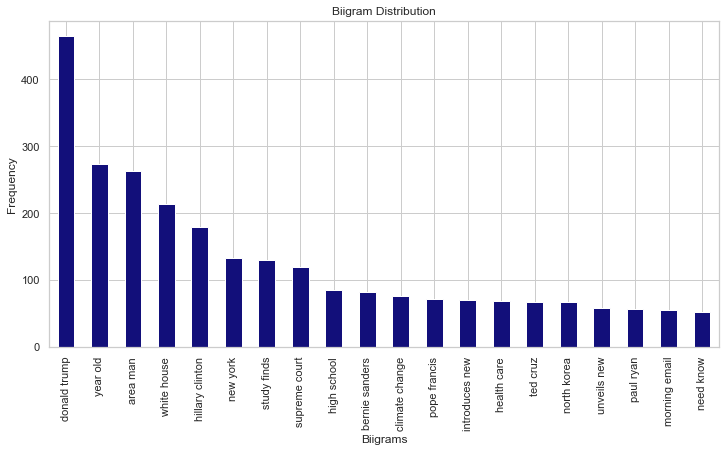

In [14]:
plot_ngram(bigram_words)
plt.title('Biigram Distribution')
plt.xlabel("Biigrams")
plt.ylabel("Frequency");

## Wordcloud

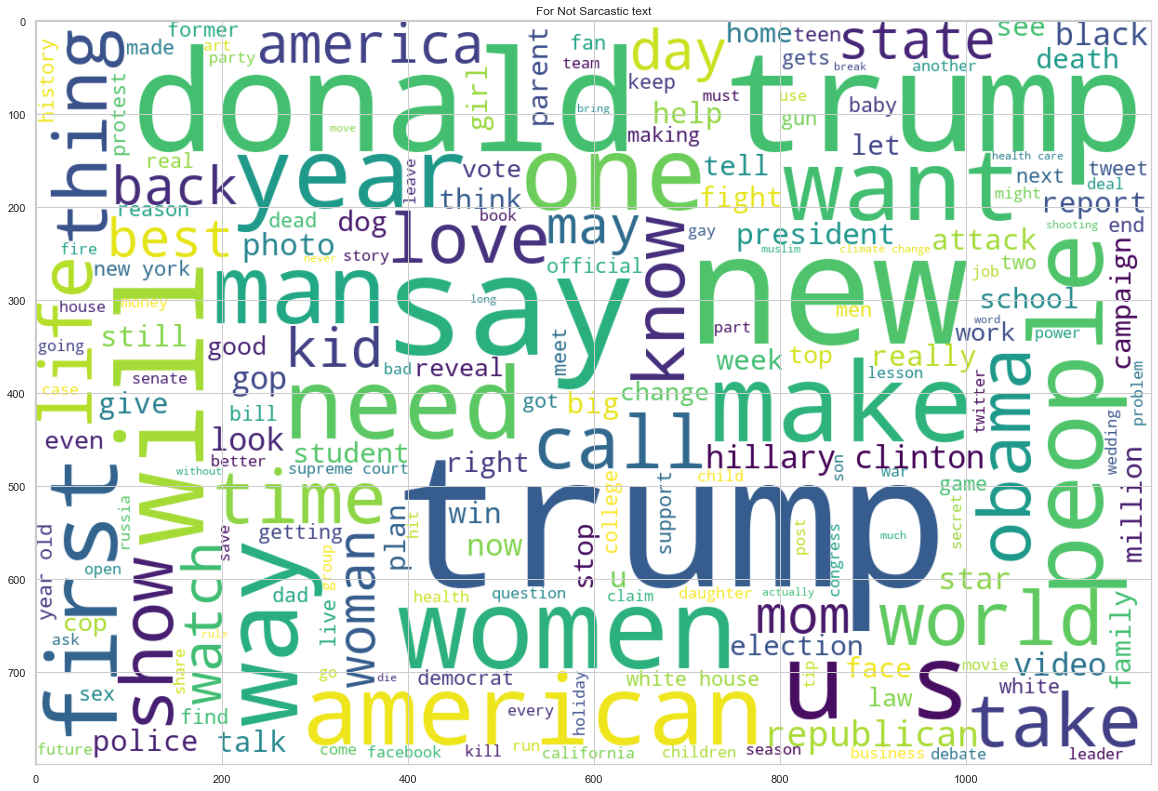

In [15]:
from wordcloud import WordCloud
plt.figure(figsize = (20,20))
wc = WordCloud(
        max_font_size=200,
        max_words=200,
        width=1200,
        height=800,
        background_color="white",
    ).generate(" ".join(df[df.is_sarcastic == 0].headline))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('For Not Sarcastic text');

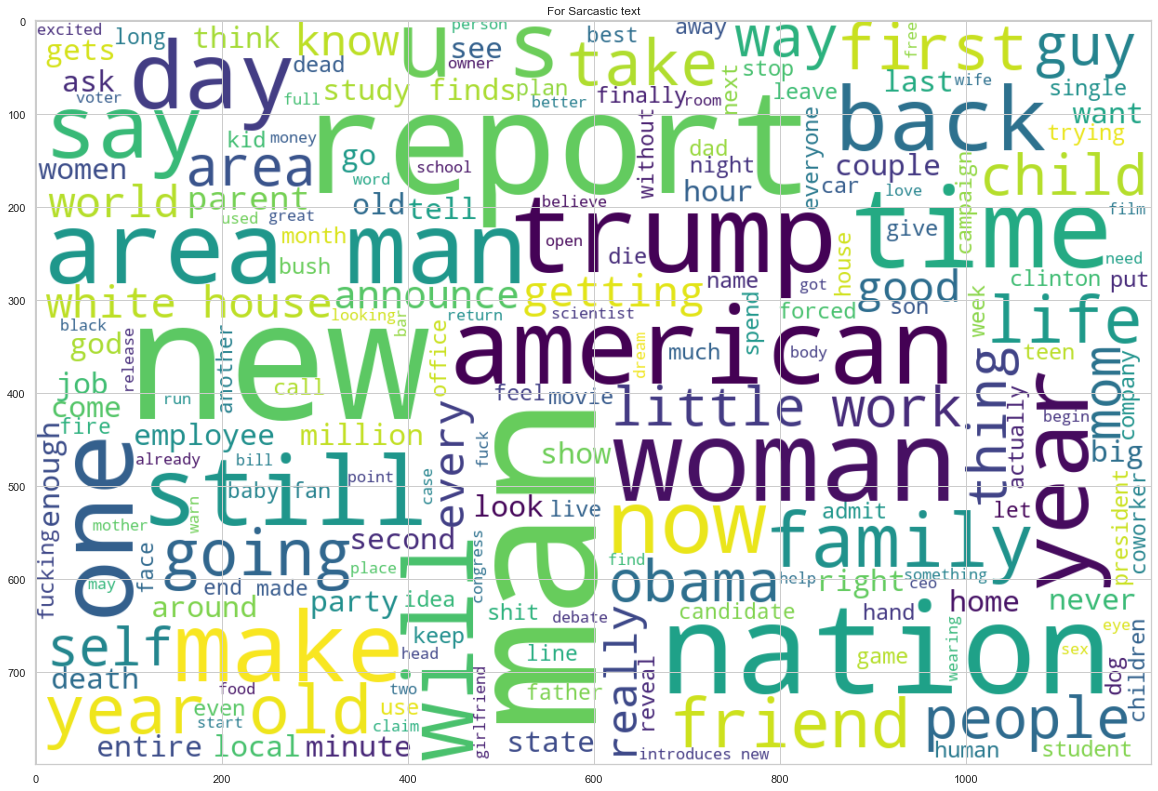

In [16]:
plt.figure(figsize = (20,20))
wc = WordCloud(
        max_font_size=200,
        max_words=200,
        width=1200,
        height=800,
        background_color="white",
    ).generate(" ".join(df[df.is_sarcastic == 1].headline))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('For Sarcastic text');